In [63]:
import os
import random
from argparse import Namespace
import copy

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Sampler, DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import umap
import scipy

from fairseq.modules import TransformerEncoderLayer

```bash
export SRC_LANG=it; CUDA_VISIBLE_DEVICES=6 fairseq-generate ${COVOST2_ROOT} --gen-subset ${SRC_LANG}_en_test \
  --task multilingual_speech_to_text --path /mnt/raid0/siqi/checkpoints/xlsr_mbart_n1_adv/checkpoint_best.pt \
  --prefix-size 1 --max-tokens 800000 --max-source-positions 800000 --beam 4 --scoring sacrebleu \
  --config-yaml config_mST.yaml --lenpen 1.0 --max-len-a 0 --max-len-b 1
```

In [2]:
langs = ["fr", "de", "es", "it", "ru", "pt", "nl", "sv-SE"] # , "sl"] # "zh-CN", "pt", "fa", "et", "mn", "nl",
         # "tr", "ar", "sv-SE", "lv", "sl", "ta", "ja", "id"]
device = 'cuda:0'

In [42]:
class MyDataset(Dataset):
    def __init__(self, langs):
        self.langs = langs
        self.data = []
        self.labels = []
        for lang_id, lang in enumerate(langs):
            for batch_idx in tqdm(os.listdir('/mnt/raid0/siqi/analysis/resources-adv/{}'.format(lang)), desc='Lang {}'.format(lang)):
                encoder_out = th.load('/mnt/raid0/siqi/analysis/resources-adv/{}/{}'.format(lang, batch_idx), map_location='cpu')[0]
                x = encoder_out.encoder_out
                padding_mask = encoder_out.encoder_padding_mask
                bsz, seqlen = padding_mask.size()
                for i in range(bsz):
                    x_i = x[:, i, :][~padding_mask[i]]
                    y_i = lang_id
                    self.data.append(x_i)
                    self.labels.append(y_i)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def __len__(self):
        return len(self.data)
    
    def collate(self, indices):
        inputs = []
        labels = []

        batch = [self[idx] for idx in indices]
        max_len = max(data.size(0) for data, _ in batch)
        padding_mask = th.zeros(len(batch), max_len).bool()
        for i, (data, label) in enumerate(batch):
            if data.size(0) < max_len:
                padding_mask[i, -(max_len - data.size(0)):] = True
                zeros = th.zeros(max_len - data.size(0), data.size(-1))
                inputs.append(th.cat([data, zeros], dim=0).unsqueeze(1))
            else:
                inputs.append(data.unsqueeze(1))
            labels.append(label)

        inputs = th.cat(inputs, dim=1)
        labels = th.LongTensor(labels)

        return inputs.to(device), padding_mask.to(device), labels.to(device)


In [43]:
dataset = MyDataset(langs)

Lang sv-SE: 100%|██████████| 52/52 [00:07<00:00,  6.86it/s]


In [44]:
th.save(dataset, '/mnt/raid0/siqi/analysis/adv_dataset.pt')

In [45]:
std_dataset = th.load('/mnt/raid0/siqi/analysis/std_dataset.pt')
adv_dataset = th.load('/mnt/raid0/siqi/analysis/adv_dataset.pt')

In [47]:
class BatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        super().__init__(dataset)
        self.dataset = dataset
        self.seqlens = [dataset[i][0].size(0) for i in range(len(dataset))]
        self.sorted_indices = sorted(zip(self.seqlens, range(len(dataset))))
        self.batch_size = batch_size

        self.all_batch_indices = []
        sum_len = 0
        batch_indices = []
        for i, seqlen in enumerate(self.seqlens):
            if sum_len + seqlen <= batch_size:
                sum_len += seqlen
                batch_indices.append(self.sorted_indices[i][1])
            else:
                self.all_batch_indices.append(batch_indices)
                sum_len = seqlen
                batch_indices = [self.sorted_indices[i][1]]
        if sum_len > 0:
            self.all_batch_indices.append(batch_indices)
            
    def __len__(self):
        return len(self.all_batch_indices)

    def __iter__(self):
        permuted_all_batch_indices = copy.deepcopy(self.all_batch_indices)
        random.shuffle(permuted_all_batch_indices)
        for batch_indices in permuted_all_batch_indices:
            yield self.dataset.collate(batch_indices)

In [48]:
batch_sampler = BatchSampler(adv_dataset, 10000)

In [61]:
class Classifier(nn.Module):
    def __init__(self, nlayer, ndim, nhid, nhead, nclass, drop=0.1) -> None:
        super().__init__()
        
        args = {
            'encoder_embed_dim': ndim,
            'encoder_attention_heads': nhead,
            'attention_dropout': drop,
            'dropout': drop,
            'activation_dropout': drop,
            'encoder_normalize_before': True,
            'encoder_ffn_embed_dim': nhid, 
        }
        args = Namespace(**args)

        self.layers = nn.ModuleList(
            [TransformerEncoderLayer(args) for _ in range(nlayer)]
        )
        self.linear = nn.Linear(ndim, nclass)

    def forward(self, x, padding_mask):
        for layer in self.layers:
            x = layer(x, padding_mask)
        logits = self.linear(x)[0]
        return logits

class Classifier2(nn.Module):
    def __init__(self, nlayer, ndim, nhid, nclass, drop=0.1) -> None:
        super().__init__()
        
        self.proj = nn.Linear(ndim, nhid)
        self.layers = nn.ModuleList([nn.Linear(nhid, nhid) for _ in range(nlayer)])
        self.linear = nn.Linear(nhid, nclass)
        self.relu = nn.ReLU()

    def forward(self, x, padding_mask):
        seqlen, bs, _ = x.size()
        x = th.cat([x[:, i, :][~padding_mask[i]].mean(dim=0).unsqueeze(0) for i in range(bs)], dim=0)

        x = self.relu(self.proj(x))
        for layer in self.layers:
            x = self.relu(layer(x))
        logits = self.linear(x)
        return logits

In [62]:
classifier = Classifier2(1, 1024, 4096, len(langs)).to(device)

In [63]:
optimizer = th.optim.Adam(classifier.parameters(), lr=1e-4)

In [64]:
loss_fn = nn.CrossEntropyLoss()

In [65]:
n_epoch = 20

In [66]:
classifier.train()
for _ in range(n_epoch):
    iterator = tqdm(batch_sampler)
    sum_loss = 0
    cnt = 0
    for inputs, padding_mask, labels in iterator:
        optimizer.zero_grad()
        logits = classifier(inputs, padding_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        cnt += 1
        iterator.set_description('Epoch {} Loss {:.2f}'.format(_ + 1, sum_loss / cnt))

Epoch 3 Loss 0.06:  38%|███▊      | 174/463 [00:04<00:07, 37.03it/s]


KeyboardInterrupt: 

# TSNE/UMAP with respect to language

In [28]:
all_features = []
n_labels = [0] * len(langs)
for seq_feature, lang in tqdm(dataset):
    feature = seq_feature.mean(dim=0).unsqueeze(0).cpu().numpy()
    n_labels[lang] += 1
    all_features.append(feature)
all_features = np.concatenate(all_features)

100%|██████████| 64060/64060 [00:44<00:00, 1440.26it/s]


In [29]:
np.save('std_ft.npy', all_features)
np.save('std_n_labels', n_labels)

In [34]:
all_features = np.load('std_ft.npy')
n_labels = np.load('std_n_labels.npy')

In [35]:
projector = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', init='spectral', verbose=True)
dots = projector.fit_transform(all_features)

UMAP(angular_rp_forest=True, metric='cosine', verbose=True)
Tue Feb 15 13:01:36 2022 Construct fuzzy simplicial set
Tue Feb 15 13:01:36 2022 Finding Nearest Neighbors
Tue Feb 15 13:01:37 2022 Building RP forest with 18 trees
Tue Feb 15 13:01:41 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Tue Feb 15 13:01:54 2022 Finished Nearest Neighbor Search
Tue Feb 15 13:01:56 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Feb 15 13:02:38 2022 Finished embedding


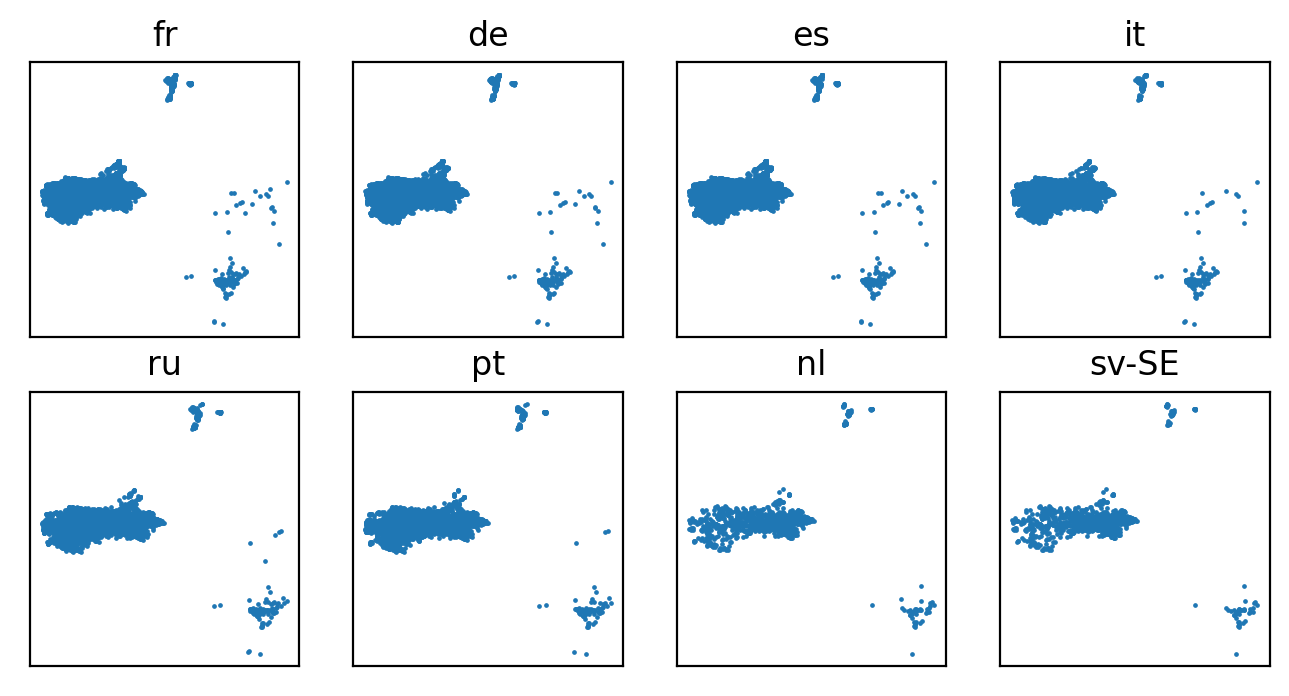

In [36]:
cnt = 0
fig, axs = plt.subplots(2, 4, dpi=200, figsize=(8, 4))
for idx, lang in enumerate(langs):
    ax = axs[idx // 4, idx % 4]
    ax.scatter(*zip(*dots[cnt:cnt + n_labels[idx]]), label=lang, s=0.5)
    ax.set_title(lang)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('std.png')

# Frechet Distance

In [91]:
all_features = np.load('adv_ft.npy')
n_labels = np.load('adv_n_labels.npy')

In [92]:
cnt = 0
means = []
covs = []
for idx, lang in enumerate(tqdm(langs)):
    lang_features = all_features[cnt:cnt + n_labels[idx]]
    mean = lang_features.mean(axis=0)
    cov = np.cov(lang_features, rowvar=False, )
    means.append(mean)
    covs.append(cov)
    cnt += n_labels[idx]

100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


In [94]:
matrix = np.zeros((len(langs), len(langs)))
for i in range(len(langs)):
    for j in tqdm(range(len(langs)), desc='lang ({}, X)'.format(langs[i])):
        if i < j:
            A = ((means[i] - means[j]) ** 2).sum()
            B = np.trace(covs[i] + covs[j] - 2 * scipy.linalg.sqrtm(np.matmul(covs[i], covs[j])))
            matrix[i, j] = (A + B) ** 0.5
        elif i > j:
            matrix[i, j] = matrix[j, i]
        else:
            matrix[i, j] = 0.

lang (fr, X):   0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_30811/4113671158.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix[i, j] = (A + B) ** 0.5
lang (sv-SE, X): 100%|██████████| 8/8 [00:00<00:00, 133152.51it/s]


/tmp/ipykernel_30811/2453059293.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + langs)
/tmp/ipykernel_30811/2453059293.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + langs)


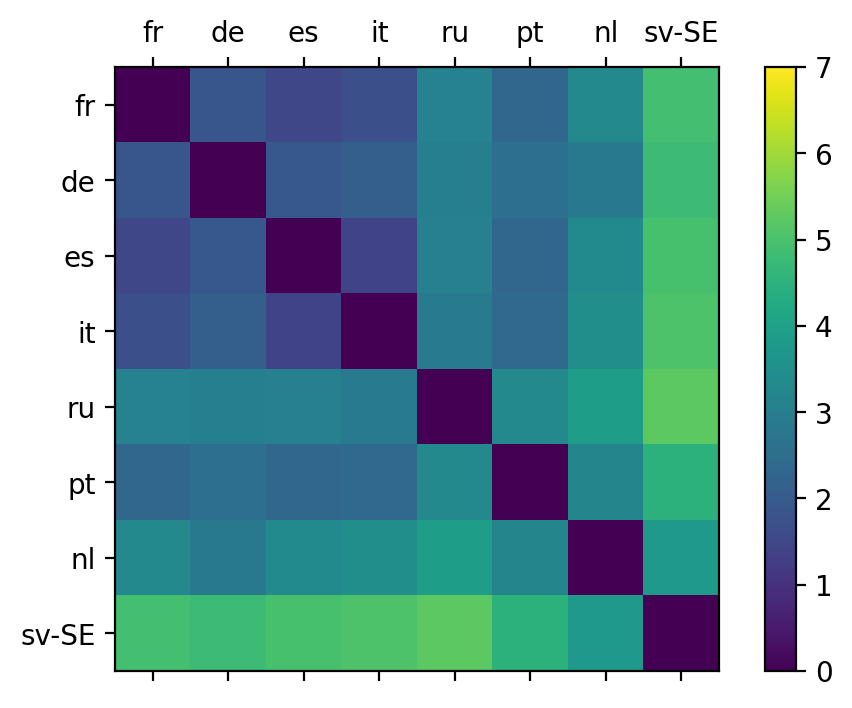

In [95]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, norm=mp.colors.Normalize(0, 7))
fig.colorbar(cax)
ax.set_xticklabels([''] + langs)
ax.set_yticklabels([''] + langs)
plt.savefig('adv_fd.png')